In [1]:
%matplotlib inline
from scipy.stats import kurtosis, skew
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error
import statsmodels.api as sm
import dcor
#import warnings
#warnings.filterwarnings("ignore")

# 1. Data Importing

# 1.1 Import 11 Select Spdrs (e.g. XLF, XLE, etc.).

In [2]:
spdrs_list = ['XLB','XLC','XLE','XLF','XLI','XLK','XLP','XLRE','XLU','XLV','XLY']     

spdrs_stat_date = datetime.datetime(2014, 1, 1)
spdrs_end_date = datetime.datetime(2019, 12, 31)

spdrs_price_df = pd.DataFrame()

for spdrs_name in spdrs_list:        
    df = data.get_data_yahoo(spdrs_name, spdrs_stat_date, spdrs_end_date)
    spdrs_price_df[spdrs_name] = df['Adj Close']
    
spdrs_price_df
# You will see XLC and XLRE have missing data we will select ohter ETF in question 1.2

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2013-12-31,39.781387,NaN,66.326424,15.372337,45.100849,31.869316,35.226295,NaN,29.487286,49.048355,60.550556
2014-01-02,39.462929,NaN,65.382210,15.287949,44.470848,31.557217,34.791908,NaN,29.036858,48.774105,60.269672
2014-01-03,39.368259,NaN,65.142441,15.393431,44.591675,31.405630,34.726334,NaN,28.943678,48.889114,60.106598
2014-01-06,39.153088,NaN,65.232361,15.407503,44.332764,31.352112,34.595215,NaN,28.990271,48.685623,59.735107
2014-01-07,39.084229,NaN,65.726936,15.414529,44.608921,31.637468,34.783710,NaN,29.246548,49.198750,60.097538
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,59.291908,53.133064,55.247555,29.654032,79.649132,89.694038,60.466576,36.189701,60.928539,99.836365,122.781921
2019-12-26,59.553837,53.538132,55.229717,29.818348,79.834190,90.362526,60.524250,36.408398,61.033138,99.768501,124.280457
2019-12-27,59.330715,53.439335,54.997887,29.741024,79.765999,90.352684,60.793369,36.541515,61.213787,99.797585,124.270607


# 1.2 Import your equity ETF prices for 2014 - 2019.

### From file : Ref_1_Find_other_ETF_to_replace_XLC _and_XLRE.ipynb, 
### Our ETF are 
### - VOX (Vanguard Communication Services Index Fund ETF Shares) and 
### - IYR (iShares U.S. Real Estate ETF)
### (we will replace XLC with VOX and replace XLRE with IYR)

In [3]:
spdrs_list = ['XLB','VOX','XLE','XLF','XLI','XLK','XLP','IYR','XLU','XLV','XLY']     # XLC ==> VOX, XLRE ==> IYR

spdrs_stat_date = datetime.datetime(2014, 1, 1)
spdrs_end_date = datetime.datetime(2019, 12, 31)

spdrs_price_df = pd.DataFrame()

for spdrs_name in spdrs_list:        
    df = data.get_data_yahoo(spdrs_name, spdrs_stat_date, spdrs_end_date)
    spdrs_price_df[spdrs_name] = df['Adj Close']
    
spdrs_price_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2013-12-31,39.781387,72.149460,66.326424,15.372337,45.100849,31.869316,35.226295,48.451271,29.487286,49.048355,60.550556
2014-01-02,39.462929,71.528519,65.382210,15.287949,44.470848,31.557217,34.791908,48.374454,29.036858,48.774105,60.269672
2014-01-03,39.368259,71.321556,65.142441,15.393431,44.591675,31.405630,34.726334,48.658653,28.943678,48.889114,60.106598
2014-01-06,39.153088,71.571640,65.232361,15.407503,44.332764,31.352112,34.595215,48.858345,28.990271,48.685623,59.735107
2014-01-07,39.084229,72.080452,65.726936,15.414529,44.608921,31.637468,34.783710,49.027328,29.246548,49.198750,60.097538
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,59.291908,92.998398,55.247555,29.654032,79.649132,89.694038,60.466576,88.187439,60.928539,99.836365,122.781921
2019-12-26,59.553837,93.719543,55.229717,29.818348,79.834190,90.362526,60.524250,88.658531,61.033138,99.768501,124.280457
2019-12-27,59.330715,93.541725,54.997887,29.741024,79.765999,90.352684,60.793369,88.898865,61.213787,99.797585,124.270607


In [4]:
# Check that all data is non-null and DatetimeIndex
spdrs_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2013-12-31 to 2019-12-31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     1511 non-null   float64
 1   VOX     1511 non-null   float64
 2   XLE     1511 non-null   float64
 3   XLF     1511 non-null   float64
 4   XLI     1511 non-null   float64
 5   XLK     1511 non-null   float64
 6   XLP     1511 non-null   float64
 7   IYR     1511 non-null   float64
 8   XLU     1511 non-null   float64
 9   XLV     1511 non-null   float64
 10  XLY     1511 non-null   float64
dtypes: float64(11)
memory usage: 141.7 KB


# 1.3 Import the data series corresponding to the Leading Economic Indicators (LEI), Coincidental Economic Indicators (CEI), and Lagging Economic Indicators (LAG).

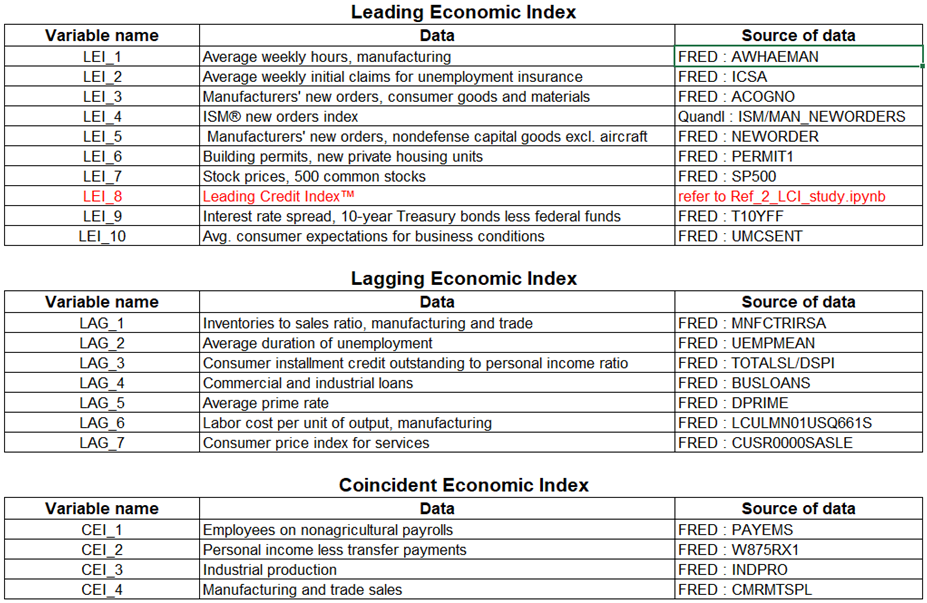

In [5]:
# Determine start and end of data
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 12, 31)

### LEI_1 (Average weekly hours, manufacturing)

In [6]:
LEI_1 = data.DataReader('AWHAEMAN', 'fred', start, end)
LEI_1.head(2)

,AWHAEMAN
DATE,
2014-01-01,40.7
2014-02-01,40.7


### LEI_2 (Average weekly initial claims for unemployment insurance)

In [7]:
# Import data
LEI_2 = data.DataReader('ICSA', 'fred', start, end)
# Set datetime 
LEI_2 = LEI_2.reset_index()
LEI_2.DATE = pd.to_datetime(LEI_2.DATE)
# Biweekly to Monthly
LEI_2 = LEI_2.resample('M', on = 'DATE').sum()
LEI_2.head(2)

,ICSA
DATE,
2014-01-31,1307000
2014-02-28,1341000


### LEI_3 (Manufacturers' new orders, consumer goods and materials)

In [8]:
LEI_3 = data.DataReader('ACOGNO', 'fred', start, end)
LEI_3.head(2)

,ACOGNO
DATE,
2014-01-01,210225.0
2014-02-01,214158.0


### LEI_4 (ISM® new orders index)

#### You need to have api_key

In [9]:
my_key = '9LaEgGA2RS5gj7bNHnHm'
LEI_4 = data.DataReader('ISM/MAN_NEWORDERS', 'quandl', start, end, api_key = my_key)
LEI_4 = LEI_4[['Index']].sort_index()
LEI_4.head(2)

,Index
Date,
2014-01-01,51.2
2014-02-01,54.5


### LEI_5 (Manufacturers' new orders, nondefense capital goods excl. aircraft)

In [10]:
LEI_5 = data.DataReader('NEWORDER', 'fred', start, end)
LEI_5.head(2)

,NEWORDER
DATE,
2014-01-01,68237.0
2014-02-01,67386.0


### LEI_6 (Building permits, new private housing units)

In [11]:
LEI_6 = data.DataReader('PERMIT1', 'fred', start, end)
LEI_6.head(2)

,PERMIT1
DATE,
2014-01-01,615.0
2014-02-01,609.0


### LEI_7 (Stock prices, 500 common stocks)

In [12]:
# Import data
LEI_7 = data.DataReader('SP500', 'fred', start, end)
# Set datetime 
LEI_7 = LEI_7.reset_index()
LEI_7.DATE = pd.to_datetime(LEI_7.DATE)
# Daily to Monthly
LEI_7 = LEI_7.resample('M', on = 'DATE').mean()
LEI_7.head(2)

,SP500
DATE,
2014-01-31,1822.356667
2014-02-28,1817.034737


### LEI_8 (Leading Credit Index™)

Reference :

Levanon, Gad and Ozyildirim, Ataman and Manini, Jean Claude and Schaitkin, Brian and Tanchua, Jennelyn, Using a Leading Credit Index to Predict Turning Points in the U.S. Business Cycle (December 20, 2011). The Conference Board Economics Program Working Paper No. 11-05, Available at SSRN: https://ssrn.com/abstract=1979777 or http://dx.doi.org/10.2139/ssrn.1979777

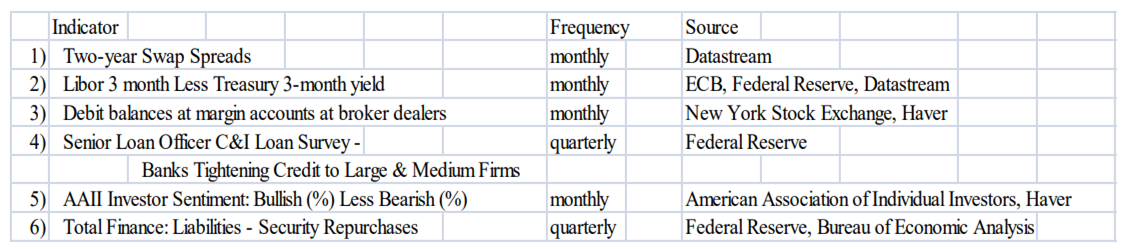

### This code come from Ref_2_LCI_study_with_comments.ipynb

In [13]:
############################################## Two-year Swap Spreads #################################################
SWP_old = data.DataReader('DSWP2', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2014, 7, 31))
SWP_old.columns = ['2_yrs_swap_rate']
# Get 2 years swap rate second period
SWP_new = data.DataReader('ICERATES1100USD2Y', 'fred', datetime.datetime(2014, 8, 1), datetime.datetime(2019, 12, 31))
SWP_new.columns = ['2_yrs_swap_rate']
# Combine 2 years swap rate of 2 periods
_2yrs_swap_rate = SWP_old.append(SWP_new)

# Get 2 years tbill yield
_2yrs_tbill = data.DataReader('DGS2', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2019, 12, 31))
_2yrs_tbill.columns = ['2_yrs_treasury_yield']

# Calculte 2 years swap spread
_2yrs_swap_spread_daily = pd.DataFrame(_2yrs_swap_rate.values - _2yrs_tbill.values, 
                                 index = _2yrs_swap_rate.index, columns = ['2_yrs_swap_spread'])

# deal with missing value
_2yrs_swap_spread_daily = _2yrs_swap_spread_daily.interpolate().fillna(method = 'bfill')

# Monthly 2 years swap spread
_2yrs_swap_spread_daily = _2yrs_swap_spread_daily.reset_index()
_2yrs_swap_spread_daily.DATE = pd.to_datetime(_2yrs_swap_spread_daily.DATE)
_2yrs_swap_spread = _2yrs_swap_spread_daily.resample('M', on = 'DATE').mean()
_2yrs_swap_spread = _2yrs_swap_spread[['2_yrs_swap_spread']]

##################################  LIBOR 3 month less 3 month Treasury-Bill yield spread #############################
TED_spread_daily = data.DataReader('TEDRATE', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2019, 12, 31))
TED_spread_daily.columns = ['3M LIBOR - 3M TBILL']

# Deal with missing value
TED_spread_daily = TED_spread_daily.interpolate().fillna(method = 'bfill')

# Daily to Monthly 
TED_spread_daily = TED_spread_daily.reset_index()
TED_spread_daily.DATE = pd.to_datetime(TED_spread_daily.DATE)
TED_spread = TED_spread_daily.resample('M', on = 'DATE').mean()
TED_spread = TED_spread[['3M LIBOR - 3M TBILL']]

###################################### Debit balances at margin account at broker dealer###############################
# Data from https://www.finra.org/investors/learn-to-invest/advanced-investing/margin-statistics
debit_balance = pd.read_excel('https://www.finra.org/sites/default/files/2021-03/margin-statistics.xlsx', 
                              index_col = 'Year-Month', parse_dates = True)
debit_balance = debit_balance[["Debit Balances in Customers' Securities Margin Accounts"]].sort_index()
debit_balance.columns = ['debit_balance']
debit_balance = debit_balance['2014-01-01' : '2019-12-31']

#################################### AAII Investors Sentiment Bullish (%) less Bearish (%)#############################
# Select User-Agent from http://www.useragentstring.com/pages/useragentstring.php
hdr = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
# Data from https://www.aaii.com/sentimentsurvey/sent_results
reg_url = 'https://www.aaii.com/files/surveys/sentiment.xls'
resp = requests.get(reg_url, headers = hdr).content
investor_sentiment = pd.read_excel(resp, usecols=[0, 1, 3, 6], names=['Date', 'Bull', 'Bear', 'Bull - Bear'],
                                   index_col = 'Date' , parse_dates = True)
# Set datetime 
investor_sentiment = investor_sentiment['1987-06-26 00:00:00' : '2021-08-12 00:00:00'] # know from investor_sentiment.index
investor_sentiment_biweekly = investor_sentiment.reset_index()
investor_sentiment_biweekly.Date = pd.to_datetime(investor_sentiment_biweekly.Date)

# Deal with missing value
investor_sentiment_biweekly = investor_sentiment_biweekly.interpolate().fillna(method = 'bfill')

# Biweekly to Monthly
investor_sentiment = investor_sentiment_biweekly.resample('M', on = 'Date').mean()
investor_sentiment = investor_sentiment[['Bull - Bear']]
investor_sentiment = investor_sentiment[datetime.datetime(2014, 1, 1) : datetime.datetime(2020, 1, 1)]

################ Senior Loan Officers C&I loan survey – Bank tightening Credit to Large and Medium Firms #############
# Senior Loan Officers C&I loan survey – Bank tightening Credit to Large and Medium Firms
loan_survey = data.DataReader('DRTSCILM', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1))
loan_survey.columns = ['Senior Loan Officers C&I loan survey']

# Set datetime 
loan_survey = loan_survey.reset_index()
loan_survey['DATE'] = pd.to_datetime(loan_survey['DATE']).dt.to_period('M')

# Deal with missing value
loan_survey = loan_survey.set_index('DATE').resample('M').interpolate()
loan_survey = loan_survey[datetime.datetime(2014, 1, 1) : datetime.datetime(2019, 12, 31)]

################################### Total Finance: Liabilities – Security Repurchase #################################
sec_repo = data.DataReader('FBLSRAQ027S', 'fred', datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1))
sec_repo.columns = ['Security_Repurchase']
sec_repo = sec_repo.reset_index()
sec_repo['DATE'] = pd.to_datetime(sec_repo['DATE']).dt.to_period('M')
sec_repo = sec_repo.set_index('DATE').resample('M').interpolate()
sec_repo = sec_repo[datetime.datetime(2014, 1, 1) : datetime.datetime(2019, 12, 31)]

############################################# Create Leading Credit Index ############################################
# array
LCI_component_array = np.hstack((_2yrs_swap_spread.values, 
                           TED_spread.values, 
                           debit_balance.values, 
                           investor_sentiment.values, 
                           loan_survey.values, 
                           sec_repo.values))
columns=['_2yrs_swap_spread', 'TED_spread', 'debit_balance', 'investor_sentiment', 'loan_survey', 'sec_repo']

# dataframe
LCI_component_df = pd.DataFrame(LCI_component_array, index=sec_repo.index, columns=columns)

# Instantiate and fit PCA model
scaler1 = StandardScaler()
LCI_component_standardized = scaler1.fit_transform(LCI_component_df)

pca6 = PCA(n_components=6)
PCA6_scores_array = pca6.fit_transform(LCI_component_standardized)
PCA6_scores_df = pd.DataFrame(PCA6_scores_array, index = sec_repo.index, 
                              columns = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6'])

LCI_index = PCA6_scores_df[['C_1']]
LCI_index.columns = ['LCI_index']
LEI_8 = LCI_index
LEI_8.head(2)

,LCI_index
DATE,
2014-01,1.004200
2014-02,0.909337


### LEI_9 (Interest rate spread, 10-year Treasury bonds less federal funds)

In [14]:
# Import data
LEI_9 = data.DataReader('T10YFF', 'fred', start, end)
# Set datetime 
LEI_9 = LEI_9.reset_index()
LEI_9.DATE = pd.to_datetime(LEI_9.DATE)
# Daily to Monthly
LEI_9 = LEI_9.resample('M', on = 'DATE').mean()
LEI_9.head(2)

,T10YFF
DATE,
2014-01-31,2.786667
2014-02-28,2.642105


### LEI_10 (Avg. consumer expectations for business conditions)

In [15]:
LEI_10 = data.DataReader('UMCSENT', 'fred', start, end)
LEI_10.head(2)

,UMCSENT
DATE,
2014-01-01,81.2
2014-02-01,81.6


### LEI_component_df  (dataframe of all LEI)

In [16]:
# Place the DataFrames side by side
# Combined 10 indicators as array
LEI_component_array = np.hstack((LEI_1.values, LEI_2.values, LEI_3.values, LEI_4.values, LEI_5.values,
                                 LEI_6.values, LEI_7.values, LEI_8.values, LEI_9.values, LEI_10.values,))
# Create column name
columns_LEI = ['weekly_hours', 'initial claims', 'new orders', 'ISM', 'new orders excl. aircraft', 'Building permits',
               'SP500', 'Leading Credit Index', '10yrTbill less federal funds', 'consumer expectations']

# Combined 10 indicators as df
LEI_component_df = pd.DataFrame(LEI_component_array, index=LEI_8.index, columns=columns_LEI)
LEI_component_df.head(2)

,weekly_hours,initial claims,new orders,ISM,new orders excl. aircraft,Building permits,SP500,Leading Credit Index,10yrTbill less federal funds,consumer expectations
DATE,,,,,,,,,,
2014-01,40.7,1307000.0,210225.0,51.2,68237.0,615.0,1822.356667,1.004200,2.786667,81.2
2014-02,40.7,1341000.0,214158.0,54.5,67386.0,609.0,1817.034737,0.909337,2.642105,81.6


### LAG_1 (Inventories to sales ratio, manufacturing and trade)

In [17]:
LAG_1 = data.DataReader('MNFCTRIRSA', 'fred', start, end)
LAG_1.head(2)

,MNFCTRIRSA
DATE,
2014-01-01,1.30
2014-02-01,1.29


### LAG_2 (Average duration of unemployment)

In [18]:
LAG_2 = data.DataReader('UEMPMEAN', 'fred', start, end)
LAG_2.head(2)

,UEMPMEAN
DATE,
2014-01-01,35.1
2014-02-01,36.5


### LAG_3 (Consumer installment credit outstanding to personal income ratio)

In [19]:
consumer_credit = data.DataReader('TOTALSL', 'fred', start, end)
Disposable_personal_income = data.DataReader('DSPI', 'fred', start, end)
credit_outstanding_to_personal_income = pd.DataFrame(consumer_credit.values/Disposable_personal_income.values,
                                                     index = consumer_credit.index,
                                                     columns = ['LAG_3'])
LAG_3 = credit_outstanding_to_personal_income
LAG_3.head(2)

,LAG_3
DATE,
2014-01-01,0.242955
2014-02-01,0.242806


### LAG_4 (Commercial and industrial loans)

In [20]:
LAG_4 = data.DataReader('BUSLOANS', 'fred', start, end)
LAG_4.head(2)

,BUSLOANS
DATE,
2014-01-01,1586.8147
2014-02-01,1619.9149


### LAG_5 (Average prime rate)

In [21]:
# Import data
LAG_5 = data.DataReader('DPRIME', 'fred', start, end)
# Set datetime 
LAG_5 = LAG_5.reset_index()
LAG_5.DATE = pd.to_datetime(LAG_5.DATE)
# Daily to Monthly
LAG_5 = LAG_5.resample('M', on = 'DATE').mean()
LAG_5.head(2)

,DPRIME
DATE,
2014-01-31,3.25
2014-02-28,3.25


### LAG_6 (Labor cost per unit of output, manufacturing)

In [22]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 1, 1)

# Import data
LAG_6 = data.DataReader('LCULMN01USQ661S', 'fred', start, end)
# Set datetime and Quarterly to Monthly
LAG_6 = LAG_6.reset_index()
LAG_6.DATE = pd.to_datetime(LAG_6.DATE).dt.to_period('M')

# Deal with missing value
LAG_6 = LAG_6.set_index('DATE').resample('M').interpolate()
LAG_6 = LAG_6[datetime.datetime(2014, 1, 1) : datetime.datetime(2019, 12, 31)]
LAG_6.head(2)

,LCULMN01USQ661S
DATE,
2014-01,95.328058
2014-02,95.118767


### LAG_7 (Consumer price index for services)

In [23]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 12, 31)

LAG_7 = data.DataReader('CUSR0000SASLE', 'fred', start, end)
LAG_7.head(2)

,CUSR0000SASLE
DATE,
2014-01-01,290.063
2014-02-01,290.590


### LAG_component_df (dataframe of all LAG)

In [24]:
# Combined 7 indicators as array
LAG_component_array = np.hstack((LAG_1.values, LAG_2.values, LAG_3.values, LAG_4.values, 
                                 LAG_5.values, LAG_6.values, LAG_7.values))

# Create column name
columns_LAG = ['Inventories to sales ratio', 'Average duration', 'credit outstanding to personal income', 
               'Commercial and industrial loans', 'Average prime rate', 'Labor cost per unit of output',
               'Consumer price index']

# Combined 7 indicators as df
LAG_component_df = pd.DataFrame(LAG_component_array, index = LAG_6.index, columns = columns_LAG)
LAG_component_df.head(2)

,Inventories to sales ratio,Average duration,credit outstanding to personal income,Commercial and industrial loans,Average prime rate,Labor cost per unit of output,Consumer price index
DATE,,,,,,,
2014-01,1.30,35.1,0.242955,1586.8147,3.25,95.328058,290.063
2014-02,1.29,36.5,0.242806,1619.9149,3.25,95.118767,290.590


### CEI_1 (Employees on nonagricultural payrolls)

In [25]:
CEI_1 = data.DataReader('PAYEMS', 'fred', start, end)
CEI_1.head(2)

,PAYEMS
DATE,
2014-01-01,137548
2014-02-01,137714


### CEI_2 (Personal income less transfer payments)

In [26]:
CEI_2 = data.DataReader('W875RX1', 'fred', start, end)
CEI_2.head(2)

,W875RX1
DATE,
2014-01-01,11800.5
2014-02-01,11870.9


### CEI_3 (Industrial production)

In [27]:
CEI_3 = data.DataReader('INDPRO', 'fred', start, end)
CEI_3.head(2)

,INDPRO
DATE,
2014-01-01,100.0380
2014-02-01,100.7918


### CEI_4 (Manufacturing and trade sales)

In [28]:
CEI_4 = data.DataReader('CMRMTSPL', 'fred', start, end)
CEI_4.head(2)

,CMRMTSPL
DATE,
2014-01-01,1328414.0
2014-02-01,1339979.0


### CEI_component_df (dataframe of all CEI)

In [29]:
# Combined 4 indicators as array
CEI_component_array = np.hstack((CEI_1.values, CEI_2.values, CEI_3.values, CEI_4.values))

# Create column name
columns_CEI = ['Employees on nonagricultural payrolls', 'Personal income less transfer payments', 
         'Industrial production', 'Manufacturing and trade sales']

# Combined 4 indicators df
CEI_component_df = pd.DataFrame(CEI_component_array, index = CEI_4.index, columns = columns_CEI)
CEI_component_df.head(2)

,Employees on nonagricultural payrolls,Personal income less transfer payments,Industrial production,Manufacturing and trade sales
DATE,,,,
2014-01-01,137548.0,11800.5,100.0380,1328414.0
2014-02-01,137714.0,11870.9,100.7918,1339979.0


### 21_EI_df (that is dataframe of all 21 EI)

In [30]:
# Combined 21 indicators as array
_21_EI_array = np.hstack((LEI_component_array, LAG_component_array, CEI_component_array))

# Create column name by combining column name of LET LAG CEI
columns_21 = columns_LEI + columns_LAG + columns_CEI

# Combined 21 indicators as array
_21_EI_df = pd.DataFrame(_21_EI_array, index = CEI_4.index, columns = columns_21)
_21_EI_df.head(2)

,weekly_hours,initial claims,new orders,ISM,new orders excl. aircraft,Building permits,SP500,Leading Credit Index,10yrTbill less federal funds,consumer expectations,...,Average duration,credit outstanding to personal income,Commercial and industrial loans,Average prime rate,Labor cost per unit of output,Consumer price index,Employees on nonagricultural payrolls,Personal income less transfer payments,Industrial production,Manufacturing and trade sales
DATE,,,,,,,,,,,,,,,,,,,,,
2014-01-01,40.7,1307000.0,210225.0,51.2,68237.0,615.0,1822.356667,1.004200,2.786667,81.2,...,35.1,0.242955,1586.8147,3.25,95.328058,290.063,137548.0,11800.5,100.0380,1328414.0
2014-02-01,40.7,1341000.0,214158.0,54.5,67386.0,609.0,1817.034737,0.909337,2.642105,81.6,...,36.5,0.242806,1619.9149,3.25,95.118767,290.590,137714.0,11870.9,100.7918,1339979.0


# 2. Data Processing

# 2.1 Compute the daily returns of your Equity ETF and SPDRs

In [31]:
# From question 1.1, we have the price of 11 ETFs
spdrs_price_df.head(3)

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2013-12-31,39.781387,72.149460,66.326424,15.372337,45.100849,31.869316,35.226295,48.451271,29.487286,49.048355,60.550556
2014-01-02,39.462929,71.528519,65.382210,15.287949,44.470848,31.557217,34.791908,48.374454,29.036858,48.774105,60.269672
2014-01-03,39.368259,71.321556,65.142441,15.393431,44.591675,31.405630,34.726334,48.658653,28.943678,48.889114,60.106598


In [32]:
# Create empty df
spdrs_daily_logret_df = pd.DataFrame()

for i in spdrs_price_df.columns:
    # Compute daily return
    spdrs_daily_logret_df[i] = np.log(spdrs_price_df[i].astype('float64')/spdrs_price_df[i].astype('float64').shift(1))

# Deal with NaN
spdrs_daily_logret_df= spdrs_daily_logret_df.dropna()

spdrs_daily_logret_df.head(2)

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-02,-0.008037,-0.008644,-0.014338,-0.005505,-0.014067,-0.009841,-0.012408,-0.001587,-0.015393,-0.005607,-0.004650
2014-01-03,-0.002402,-0.002898,-0.003674,0.006876,0.002713,-0.004815,-0.001887,0.005858,-0.003214,0.002355,-0.002709


In [33]:
# Compute monthly return from daily return
sp = spdrs_daily_logret_df.reset_index()
sp['mdate'] = sp['Date'].dt.to_period('M')

spdrs_monthly_logret_df = pd.DataFrame()
group = sp.groupby(['mdate'])
for j in spdrs_daily_logret_df.columns:
    spdrs_monthly_logret_df[j] = group[j].transform(np.sum)

spdrs_monthly_logret_df = spdrs_monthly_logret_df.drop_duplicates(subset = spdrs_daily_logret_df.columns, keep = 'first')
spdrs_monthly_logret_df.index = sp['mdate'].drop_duplicates()

spdrs_monthly_logret_df.head(2)

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
mdate,,,,,,,,,,,
2014-01,-0.048314,-0.028369,-0.059707,-0.037283,-0.043609,-0.026079,-0.053033,0.033822,0.029326,0.009336,-0.061879
2014-02,0.066750,-0.006415,0.049943,0.029937,0.039774,0.043002,0.038267,0.046415,0.033944,0.060330,0.062028


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html

# 3. Category 1 Models: Linear Regression

# 3.1 For each ETF (there's 11 in total!), run a regression modeling the ETF returns on the 10 Leading EI (LEI) factors.  This will give a total of 11 regression models.  Be sure to use the weights located in the link above.

In [34]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_LEI = MinMaxScaler()

# normalize Feature
LEI_component_transformed = scaler_LEI.fit_transform(LEI_component_array)
# normalize Target
spdrs_monthly_logret_transformed = scaler_LEI.fit_transform(spdrs_monthly_logret_df.values)    

In [35]:
spdrs_monthly_logret_df.columns

Index(['XLB', 'VOX', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'IYR', 'XLU', 'XLV',
       'XLY'],
      dtype='object')

In [36]:
# Linear regression model using LEI features only

# create list of ETF's name
dep = list(spdrs_monthly_logret_df.columns)

# Create empty list for keeping model information
metrics = []
for i in range(len(dep)):
    target = spdrs_monthly_logret_transformed[:,i]
    features = LEI_component_transformed
    m = sm.OLS(target,features).fit()
    metrics.append(m)

In [37]:
model_2= pd.DataFrame(dep).rename({0:'ETFS'}, axis = 1)

In [38]:
r2 = []
mse = []
aic = []
for i in metrics:
    r2.append(i.rsquared)
    mse.append(i.mse_model)
    aic.append(i.aic)
model_2['RSquared'] = r2
model_2['MSE']= mse
model_2['AIC'] = aic
display(model_2)

,ETFS,RSquared,MSE,AIC
0,XLB,0.875787,1.773690,-17.171458
1,VOX,0.872043,1.688224,-18.280441
2,XLE,0.840630,2.141780,17.300820
3,XLF,0.910238,1.905101,-38.191003
4,XLI,0.901452,2.187904,-20.804107
5,XLK,0.888492,2.240254,-9.163124
6,XLP,0.920682,3.344753,-7.393209
7,IYR,0.873831,1.635398,-21.729969
8,XLU,0.861609,2.190551,6.984390
9,XLV,0.914778,2.776048,-15.178994


# 3.2 Repeat the regression modeling, but this time use the 7 Lagging EI factors (LAG).  This will give another 11 regression models.

In [39]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_LAG = MinMaxScaler()

# normalize Feature
LAG_component_transformed = scaler_LAG.fit_transform(LAG_component_array)
# normalize Target
spdrs_monthly_logret_transformed = scaler_LAG.fit_transform(spdrs_monthly_logret_df.values)    

In [40]:
# Linear regression model using LEI features only
dep = list(spdrs_monthly_logret_df.columns)

metrics = []
for i in range(len(dep)):
    target = spdrs_monthly_logret_transformed[:,i]
    features = LAG_component_transformed
    m = sm.OLS(target,features).fit()
    metrics.append(m)

In [41]:
model_3 = pd.DataFrame(dep).rename({0:'ETFS'}, axis =1) ## Create an empty Dataframe
r2 = []
mse = []
aic = []
for i in metrics:
    r2.append(i.rsquared)
    mse.append(i.mse_model)
    aic.append(i.aic)
model_3['RSquared'] = r2
model_3['MSE']= mse
model_3['AIC'] = aic
display(model_3)

,ETFS,RSquared,MSE,AIC
0,XLB,0.883911,2.557347,-28.041679
1,VOX,0.864267,2.390243,-20.032762
2,XLE,0.849391,3.091575,7.229771
3,XLF,0.901966,2.696841,-37.844232
4,XLI,0.900746,3.123130,-26.290316
5,XLK,0.867908,3.126220,-2.966280
6,XLP,0.910083,4.723209,-4.362423
7,IYR,0.862717,2.306568,-21.651362
8,XLU,0.852335,3.095676,5.654496
9,XLV,0.897009,3.888749,-7.543351


# 3.3 Repeat the regression modeling, but this time use the 4 Coincidental EI factors (CEI).  This will give another 11 regression models

In [42]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_CEI = MinMaxScaler()

# normalize Feature
CEI_component_transformed = scaler_CEI.fit_transform(CEI_component_array)
# normalize Target
spdrs_monthly_logret_transformed = scaler_CEI.fit_transform(spdrs_monthly_logret_df.values)    

In [43]:
# Linear regression model using LEI features only
dep = list(spdrs_monthly_logret_df.columns)

metrics = []
for i in range(len(dep)):
    target = spdrs_monthly_logret_transformed[:,i]
    features = CEI_component_transformed
    m = sm.OLS(target,features).fit()
    metrics.append(m)

In [44]:
model_4 = pd.DataFrame(dep).rename({0:'ETFS'}, axis =1)## Create an empty Dataframe
r2 = []
mse = []
aic = []
for i in metrics:
    r2.append(i.rsquared)
    mse.append(i.mse_model)
    aic.append(i.aic)
model_4['RSquared'] = r2
model_4['MSE']= mse
model_4['AIC'] = aic
display(model_4)

,ETFS,RSquared,MSE,AIC
0,XLB,0.767097,3.883912,16.089608
1,VOX,0.742767,3.594885,19.996290
2,XLE,0.754504,4.805869,36.408400
3,XLF,0.777654,4.069021,15.117819
4,XLI,0.788737,4.785837,22.100230
5,XLK,0.767131,4.835633,31.856147
6,XLP,0.803260,7.295427,46.012821
7,IYR,0.750134,3.509741,15.467783
8,XLU,0.728117,4.627901,43.605454
9,XLV,0.775857,5.886170,42.446878


# 3.4 Repeat the regression one more time, using all 21 EI factors: LEI, LAG, and CEI.  This will give another 11 regression models.

In [45]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_21 = MinMaxScaler()

# normalize Feature
_21_EI_transformed = scaler_21.fit_transform(_21_EI_array)
# normalize Target
spdrs_monthly_logret_transformed = scaler_21.fit_transform(spdrs_monthly_logret_df.values)  

In [46]:
# Linear regression model using LEI features only
dep = list(spdrs_monthly_logret_df.columns)

metrics = []
for i in range(len(dep)):
    target = spdrs_monthly_logret_transformed[:,i]
    features = _21_EI_transformed
    m = sm.OLS(target,features).fit()
    metrics.append(m)

In [47]:
## Create an empty Dataframe
model = pd.DataFrame(dep).rename({0:'ETFS'}, axis =1)
r2 = []
mse = []
aic = []
for i in metrics:
    r2.append(i.rsquared)
    mse.append(i.mse_model)
    aic.append(i.aic)
model['RSquared'] = r2
model['MSE']= mse
model['AIC'] = aic
display(model)

,ETFS,RSquared,MSE,AIC
0,XLB,0.909960,0.877570,-18.336587
1,VOX,0.901615,0.831178,-15.202707
2,XLE,0.887374,1.076608,14.305337
3,XLF,0.947629,0.944457,-54.984952
4,XLI,0.937183,1.083156,-31.227389
5,XLK,0.925732,1.111501,-16.425349
6,XLP,0.935558,1.618475,-0.347985
7,IYR,0.901362,0.803297,-17.453825
8,XLU,0.877761,1.062673,20.049302
9,XLV,0.926182,1.338407,-3.522384


# 3.5 By now, you will have 3 models for XLRE: 1 using LEI, 1 using LAG, 1 using CEI, and 1 using ALL economic indicators.  Similarly, there will be 4 models for each of the other sector ETFs.

### Yes, we already have 4 models for each of the other sector ETFs

# 3.6 Use the model selection paper [Reference Above].  For each sector ETF, compare the results 3.4 with the results from questions 3.1, 3.2, and 3.3

???

# 4. Model Selection

# 4.1 For each ETF, which of the sets: LEI, LAG, or CEI, was the best model?

In [48]:
mse=model_2.MSE.to_frame('LEI')
mse['LAG'] = model_3.MSE
mse['CEI'] = model_4.MSE
mse['Best Model'] = mse.apply(lambda x: x.idxmin(),axis=1)
mse.rename(index={0: 'ETFS'})
mse

,LEI,LAG,CEI,Best Model
0,1.773690,2.557347,3.883912,LEI
1,1.688224,2.390243,3.594885,LEI
2,2.141780,3.091575,4.805869,LEI
3,1.905101,2.696841,4.069021,LEI
4,2.187904,3.123130,4.785837,LEI
5,2.240254,3.126220,4.835633,LEI
6,3.344753,4.723209,7.295427,LEI
7,1.635398,2.306568,3.509741,LEI
8,2.190551,3.095676,4.627901,LEI
9,2.776048,3.888749,5.886170,LEI


In [49]:
model_2 = model_2.set_index('ETFS')
lei_mse = model_2.MSE.sort_values()
display(lei_mse)
print(f'The best fit for LEI is {lei_mse.index[0]} with MSE = {lei_mse[0]}')

ETFS
IYR    1.635398
VOX    1.688224
XLB    1.773690
XLF    1.905101
XLE    2.141780
XLI    2.187904
XLU    2.190551
XLK    2.240254
XLY    2.457091
XLV    2.776048
XLP    3.344753
Name: MSE, dtype: float64

The best fit for LEI is IYR with MSE = 1.6353984162279205


In [50]:
model_3 = model_3.set_index('ETFS')
lag_mse = model_3.MSE.sort_values()
display(lag_mse)
print(f'The best fit for LAG is {lag_mse.index[0]} with MSE = {lag_mse[0]}')

ETFS
IYR    2.306568
VOX    2.390243
XLB    2.557347
XLF    2.696841
XLE    3.091575
XLU    3.095676
XLI    3.123130
XLK    3.126220
XLY    3.459235
XLV    3.888749
XLP    4.723209
Name: MSE, dtype: float64

The best fit for LAG is IYR with MSE = 2.306567911180249


In [51]:
model_4=model_4.set_index('ETFS')
cei_mse = model_4.MSE.sort_values()
display(cei_mse)
print(f'The best fit for CEI is {cei_mse.index[0]} with MSE = {cei_mse[0]}')

ETFS
IYR    3.509741
VOX    3.594885
XLB    3.883912
XLF    4.069021
XLU    4.627901
XLI    4.785837
XLE    4.805869
XLK    4.835633
XLY    5.428374
XLV    5.886170
XLP    7.295427
Name: MSE, dtype: float64

The best fit for CEI is IYR with MSE = 3.509741155358531


# 5. Category 2 Models: LASSO

# 5.1 For each sector ETF, run a LASSO regression with all 21 economic indicators.   

### Implementing the Lasso regression on each ETF using the 21 economic indicators

In [52]:
# same mothnly index format for v and  spdrs_monthly_logret_df
_21_EI_df.index = spdrs_monthly_logret_df.index

In [53]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_lasso = MinMaxScaler()

# normalize Feature
_21_EI_transformed = scaler_lasso.fit_transform(_21_EI_array)
_21_EI_transformed_df = pd.DataFrame(_21_EI_transformed, index=_21_EI_df.index, 
                                     columns=_21_EI_df.columns)

# normalize Target
spdrs_monthly_logret_transformed = scaler_lasso.fit_transform(spdrs_monthly_logret_df.values)  
spdrs_monthly_logret_transformed_df = pd.DataFrame(spdrs_monthly_logret_transformed, index=spdrs_monthly_logret_df.index, 
                                                   columns=spdrs_monthly_logret_df.columns)

In [54]:
lass_mse = {}

for etf in spdrs_monthly_logret_df.columns:
    data = spdrs_monthly_logret_df[[etf]].merge(_21_EI_transformed_df, 
                                                how='left', 
                                                left_on = spdrs_monthly_logret_transformed_df.index, 
                                                right_on =_21_EI_transformed_df.index)
    data.index = data['key_0']
    
    #split data
    X, y = data.drop(['key_0', etf], axis=1), data[etf]
    X_train = X.iloc[:50,:]
    X_test = X.iloc[50:,:]
    y_train = y.iloc[:50]
    y_test = y.iloc[50:]
    
    lr = Lasso()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    lass_mse[etf]= mean_squared_error(y_pred, y_test)
lass_mse = pd.DataFrame(lass_mse.items())
lass_mse = lass_mse.rename({0:'ETFs', 1:'MSE_lasso'}, axis =1)
lass_mse

,ETFs,MSE_lasso
0,XLB,0.002152
1,VOX,0.001734
2,XLE,0.004165
3,XLF,0.002583
4,XLI,0.003161
5,XLK,0.002666
6,XLP,0.001113
7,IYR,0.001269
8,XLU,0.000579
9,XLV,0.001827


# 5.2 Compare and contrast (with technical details) the results from 5.1 with the results from 3.6.  Did you come up with same conclusion?

In [55]:
mse_compare = lass_mse
mse_compare['MSE_combined_data'] = model['MSE']
mse_compare['Lasso_rank']=mse_compare.MSE_lasso.rank()
mse_compare['combined_data']=mse_compare.MSE_combined_data.rank()
mse_compare.sort_values('Lasso_rank')

,ETFs,MSE_lasso,MSE_combined_data,Lasso_rank,combined_data
8,XLU,0.000579,1.062673,1.0,5.0
6,XLP,0.001113,1.618475,2.0,11.0
7,IYR,0.001269,0.803297,3.0,1.0
1,VOX,0.001734,0.831178,4.0,2.0
9,XLV,0.001827,1.338407,5.0,10.0
0,XLB,0.002152,0.877570,6.0,3.0
10,XLY,0.002216,1.204320,7.0,9.0
3,XLF,0.002583,0.944457,8.0,4.0
5,XLK,0.002666,1.111501,9.0,8.0
4,XLI,0.003161,1.083156,10.0,7.0


# 6. Category 3 Models: Cluster Analysis

# 6.1 Using daily returns, compute a distance matrix from the correlation or covariance matrix.  Run a cluster analysis using k=3.

In [56]:
spdrs_daily_logret_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-02,-0.008037,-0.008644,-0.014338,-0.005505,-0.014067,-0.009841,-0.012408,-0.001587,-0.015393,-0.005607,-0.004650
2014-01-03,-0.002402,-0.002898,-0.003674,0.006876,0.002713,-0.004815,-0.001887,0.005858,-0.003214,0.002355,-0.002709
2014-01-06,-0.005481,0.003500,0.001379,0.000914,-0.005823,-0.001706,-0.003783,0.004096,0.001608,-0.004171,-0.006200
2014-01-07,-0.001760,0.007084,0.007553,0.000456,0.006210,0.009060,0.005434,0.003453,0.008801,0.010484,0.006049
2014-01-08,0.005928,-0.001197,-0.006979,0.003188,-0.001742,0.000000,-0.007569,-0.001568,-0.005325,0.008773,-0.002718
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.001146,-0.000955,-0.000484,0.002284,-0.004027,0.000329,0.001272,0.002729,0.001405,-0.001261,0.002251
2019-12-26,0.004408,0.007724,-0.000323,0.005526,0.002321,0.007425,0.000953,0.005328,0.001715,-0.000680,0.012131
2019-12-27,-0.003754,-0.001899,-0.004206,-0.002597,-0.000855,-0.000109,0.004437,0.002707,0.002955,0.000291,-0.000079


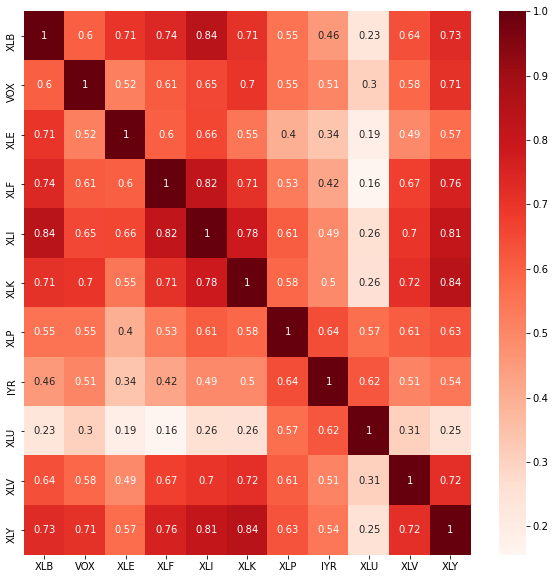

In [57]:
#Using Pearson correlation matrix

pearson_corr= spdrs_daily_logret_df.corr()

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(pearson_corr,annot=True,cmap='Reds')

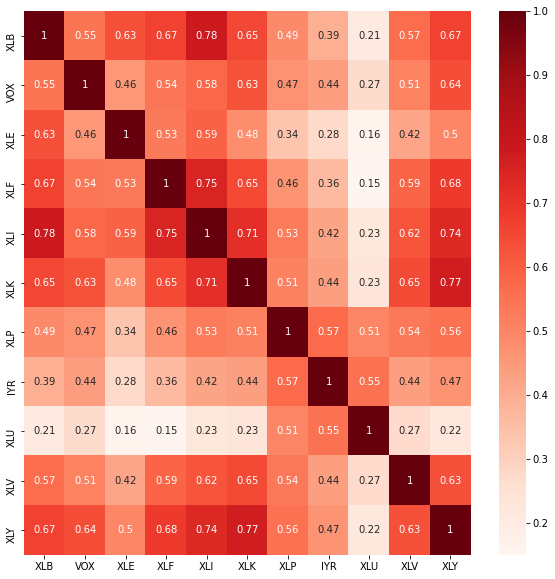

In [58]:
# computing distance correlation matrix

dist_corr = pd.DataFrame()
for i in spdrs_daily_logret_df.columns:
    for j in spdrs_daily_logret_df.columns:
        dist_corr.loc[i,j] = dcor.distance_correlation(spdrs_daily_logret_df[i], spdrs_daily_logret_df[j])

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(dist_corr,annot=True,cmap='Reds')

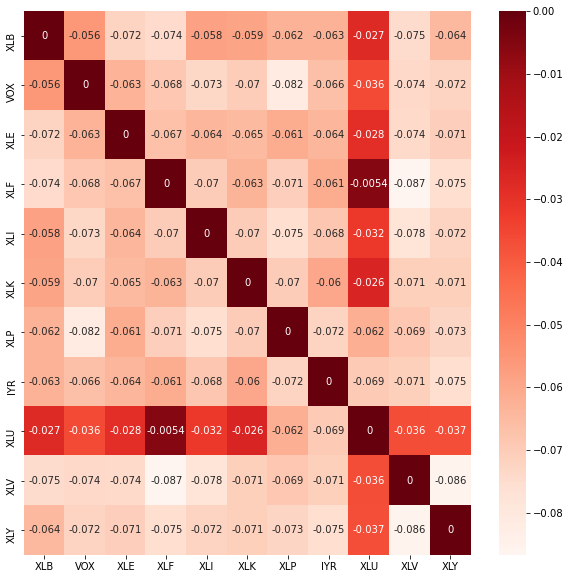

In [59]:
#calculating the major difference between pearson and dinstance correlation
diff_corr = dist_corr - pearson_corr

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(diff_corr,annot=True,cmap='Reds')

# 6.2 Compare and contrast (with technical details) the results from 6.1 with the results from 3.6 and 5.1.  Did you come up with same conclusion?

In [60]:
# fit k-means model with k=3
kmeans = KMeans(n_clusters=3).fit(spdrs_daily_logret_df)

#transform data to the cluster-distance space
distances = kmeans.transform(spdrs_daily_logret_df)
df_dist = pd.DataFrame(distances, columns = ['To_cluster1','To_cluster2','To_cluster3'])
df_dist

,To_cluster1,To_cluster2,To_cluster3
0,0.024469,0.031884,0.062187
1,0.046578,0.012540,0.034702
2,0.042048,0.012855,0.038196
3,0.065033,0.023584,0.018291
4,0.047729,0.016194,0.036139
...,...,...,...
1505,0.047178,0.006676,0.030658
1506,0.061372,0.019656,0.020829
1507,0.043838,0.007954,0.034548
1508,0.032566,0.015482,0.046029


In [61]:
#correlation matrix of distances to the cluster centers
df_dist.corr()

,To_cluster1,To_cluster2,To_cluster3
To_cluster1,1.000000,0.365502,-0.506606
To_cluster2,0.365502,1.000000,0.558440
To_cluster3,-0.506606,0.558440,1.000000


# 7. Category 4 Models: Tree

# 7.1 For each ETF, run a regression tree using all 21 economic indicators.

In [62]:
# same mothnly index format for v and  spdrs_monthly_logret_df
_21_EI_df.index = spdrs_monthly_logret_df.index

In [63]:
# Because the data in each group has different values and ranges. We need to normalize to range 0 to 1 
scaler_tree = MinMaxScaler()

# normalize Feature
_21_EI_transformed = scaler_tree.fit_transform(_21_EI_array)
_21_EI_transformed_df = pd.DataFrame(_21_EI_transformed, index=_21_EI_df.index, 
                                     columns=_21_EI_df.columns)

# normalize Target
spdrs_monthly_logret_transformed = scaler_tree.fit_transform(spdrs_monthly_logret_df.values)  
spdrs_monthly_logret_transformed_df = pd.DataFrame(spdrs_monthly_logret_transformed, index=spdrs_monthly_logret_df.index, 
                                                   columns=spdrs_monthly_logret_df.columns)

In [64]:
dt_mse = {}

for etf in spdrs_monthly_logret_df.columns:
    data = spdrs_monthly_logret_df[[etf]].merge(_21_EI_transformed_df, 
                                                how='left', 
                                                left_on = spdrs_monthly_logret_transformed_df.index, 
                                                right_on =_21_EI_transformed_df.index)
    data.index = data['key_0']
    
    #split data
    X, y = data.drop(['key_0', etf], axis=1), data[etf]
    X_train = X.iloc[:50,:]
    X_test = X.iloc[50:,:]
    y_train = y.iloc[:50]
    y_test = y.iloc[50:]
    
    dt = DecisionTreeRegressor(max_depth=10).fit(X,y)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    dt_mse[etf]= mean_squared_error(y_pred, y_test)
dt_mse = pd.DataFrame(dt_mse.items())
dt_mse = dt_mse.rename({0:'ETFs', 1:'MSE_dt'}, axis =1)
dt_mse

,ETFs,MSE_dt
0,XLB,0.010213
1,VOX,0.004750
2,XLE,0.016554
3,XLF,0.003202
4,XLI,0.005482
5,XLK,0.003071
6,XLP,0.006923
7,IYR,0.008051
8,XLU,0.004174
9,XLV,0.002321


# 7.2 Compare and contrast (with technical details) the results from 7.1 with the results from 3.4, 5.1, and 6.1.  Did you come up with same conclusion?

In [65]:
mse_compare1 = mse_compare.set_index('ETFs')
dt_mse1 = dt_mse.set_index('ETFs')
mse_compare3 = pd.concat([mse_compare1, dt_mse1], axis = 1)
mse_compare3['dt_rank']=mse_compare3.MSE_dt.rank()
mse_compare3.sort_values('MSE_dt')

,MSE_lasso,MSE_combined_data,Lasso_rank,combined_data,MSE_dt,dt_rank
ETFs,,,,,,
XLV,0.001827,1.338407,5.0,10.0,0.002321,1.0
XLK,0.002666,1.111501,9.0,8.0,0.003071,2.0
XLF,0.002583,0.944457,8.0,4.0,0.003202,3.0
XLU,0.000579,1.062673,1.0,5.0,0.004174,4.0
XLY,0.002216,1.204320,7.0,9.0,0.004423,5.0
VOX,0.001734,0.831178,4.0,2.0,0.004750,6.0
XLI,0.003161,1.083156,10.0,7.0,0.005482,7.0
XLP,0.001113,1.618475,2.0,11.0,0.006923,8.0
IYR,0.001269,0.803297,3.0,1.0,0.008051,9.0


# 8. Interpeting the Models

# 8.1 You have now found a set of sectors that regress best on Leading Indicators.  What do these sectors have in common?

In [66]:
lei_mse.rank().sort_values()

ETFS
IYR     1.0
VOX     2.0
XLB     3.0
XLF     4.0
XLE     5.0
XLI     6.0
XLU     7.0
XLK     8.0
XLY     9.0
XLV    10.0
XLP    11.0
Name: MSE, dtype: float64

**Interpretation**: The best leading indicator from the result above for 'LEI' are IYR, VOX, and XLB

# 8.2 Similarly, you have found a set of sectors that regress best on Coincidental indicators.  What do these sectors have in common?

In [67]:
cei_mse.rank().sort_values()

ETFS
IYR     1.0
VOX     2.0
XLB     3.0
XLF     4.0
XLU     5.0
XLI     6.0
XLE     7.0
XLK     8.0
XLY     9.0
XLV    10.0
XLP    11.0
Name: MSE, dtype: float64

**Interpretation**: The best leading indicator from the result above for 'LEI' are IYR, VOX, and XLB

# 8.3 Similarly, you have found a set of sectors that regress best on lagging.  What do these sectors have in common?

In [68]:
lag_mse.rank().sort_values()

ETFS
IYR     1.0
VOX     2.0
XLB     3.0
XLF     4.0
XLE     5.0
XLU     6.0
XLI     7.0
XLK     8.0
XLY     9.0
XLV    10.0
XLP    11.0
Name: MSE, dtype: float64

**Interpretation**: The best leading indicator from the result above for 'LEI' are IYR, VOX, and XLB